In [20]:
import robosuite as suite
from robosuite.controllers import load_controller_config

controller_config = load_controller_config(default_controller="OSC_POSITION")
controller_config["control_delta"] = False

# Load the environment with Kinova Gen3
env = suite.make(
    env_name="Lift",  # Choose an appropriate environment or customize
    robots="Kinova3", # Load the Kinova Gen3 robot
    controller_configs=controller_config,  # Use Operational Space Controller

    has_renderer=True,
    render_camera="sideview",  # Choose a camera for rendering
    ignore_done=True,
    use_camera_obs=False,
    has_offscreen_renderer=False,
    control_freq=20
)

# Reset environment and extract robot
obs = env.reset()

# disable delta control
env.robots[0].controller.control_delta = False
# print("env.robots[0].controller.control_delta:", env.robots[0].controller.control_delta)

# Get initial position (e.g., a position just above the table)
initial_pose = env.robots[0].controller.initial_ee_pos
print("Initial EE Position:", initial_pose)


Initial EE Position: [-0.14754875 -0.02330741  0.942508  ]


In [21]:
import numpy as np
import matplotlib.pyplot as plt
# Create a downward trajectory
def downward_trajectory(initial_pose, velocity=2.0, z_offset=0.2, duration=5.0):
    # Compute the target position
    target_pose = np.array(initial_pose)
    target_pose[2] -= z_offset

    # Compute the number of steps
    n_steps = int(duration * env.control_freq)
    steps = np.linspace(0, 1, n_steps)

    # Compute the trajectory
    trajectory = []
    for s in steps:
        # Linear interpolation
        # pose = (1 - s) * np.array(initial_pose) + s * target_pose
        # satisfy the velocity constraint
        pose = np.array(initial_pose)
        pose[2] -= velocity * duration * s
        if pose[2] < target_pose[2]:
            pose[2] = target_pose[2]
        trajectory.append(pose)
    return np.array(trajectory)



# # Visualize the downward trajectory
# trajectory = downward_trajectory(initial_pose)
# trajectory = np.array(trajectory)
# plt.plot(trajectory[:, 2])
# plt.xlabel("Time Step")
# plt.ylabel("Z-axis Position")
# plt.title("Downward Trajectory")
# plt.show()


Initial EE Position: [-0.12208467 -0.01487857  0.9581519 ]
Initial EE Orientation: [[-0.04765927  0.99872449  0.01667306]
 [ 0.99855082  0.04805543 -0.02422675]
 [-0.02499708  0.01549427 -0.99956744]]


Text(0, 0.5, 'Z-axis Position')

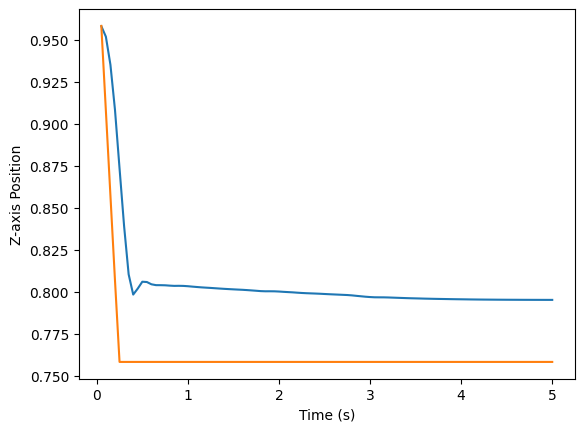

In [22]:
import time
# Reset environment and extract robot
obs = env.reset()
robot_pose = []
t_sim = []

# Get initial position (e.g., a position just above the table)
initial_pose = env.robots[0].controller.initial_ee_pos
initial_orientation = env.robots[0].controller.initial_ee_ori_mat
print("Initial EE Position:", initial_pose)
print("Initial EE Orientation:", initial_orientation)

# Get the downward trajectory
trajectory = downward_trajectory(initial_pose)

# set the render frequency
time_per_step = 1.0 / env.control_freq

for step in trajectory:
    start_time = time.time()

    # Set the controller goal to each position in the trajectory
    action = np.concatenate([step, (1,)])

    obs, reward, done, info = env.step(action)
    # change camera view
    # env.render_camera = 'sideview'
    env.render()  # Render the environment for visualization
    robot_pose.append(env.robots[0].controller.ee_pos)
    t_sim.append(env.sim.data.time)

    # sync the simulation to real-time 
    elapsed_time = time.time() - start_time
    sleep_time = time_per_step - elapsed_time
    if sleep_time > 0:
        time.sleep(sleep_time)

## Check for collision/contacts
# contacts = env.sim.data.contact  # Get contacts
# for contact in contacts:
#     print(f"Contact between geom1: {contact.geom1}, geom2: {contact.geom2}")


# Close the environment
env.close()

# plot robot pose over the desired trajectory
robot_pose = np.array(robot_pose)
plt.plot(t_sim, robot_pose[:, 2], label="actual")
plt.plot(t_sim, trajectory[:, 2], label="desired")
plt.xlabel("Time (s)")
plt.ylabel("Z-axis Position")
